# Анализ данных о заболеваемости Covid-19 в Бельгии. 

## Введение. Постановка целей и задач.


COVID-19 - это вызывающий заболевание штамм коронавируса, появившийся в декабре 2019 года и приведший к продолжающейся глобальной пандемии. По мнению Всемирной организации здравоохранения (ВОЗ), объявившей эту вспышку пандемией, COVID-19 является серьезной проблемой для общественного здравоохранения, имеющей международное значение. 
Из-за отсутствия доказанного эффективного лечения меры предосторожности считаются ВОЗ стратегическими целями и основным способом противодействия пандемии. На фоне развития пандемии COVID-19 возросла роль прогнозной аналитики.

----
Принятие решений политиками, руководителями здравоохранения разного уровня должно быть основано на точных и достоверных прогнозах количества инфицированных и заболевших, а также на основе оценки действительной динамики смертности, хотя бы в краткосрочной перспективе. **Проведение исследования данных и оставление такого прогноза развития заболеваемости и является основной целью данного исследования.**
**Наша задача** - провести анализ данных о заболеваемости Covid-19 в Бельгии, предложить и настроить прогностическую модель, выполнить прогноз и сравнить результаты с новой статистикой.

---

## Импорт библиотек, ознакомление с данными.

In [ ]:
# загружаем pmdarima
!pip install pmdarima

In [ ]:
# загружаем fbprophet
!pip install fbprophet

In [3]:
## импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# импортируем модели 
from statsmodels.tsa.statespace.sarimax import SARIMAX       
from statsmodels.tsa.seasonal import seasonal_decompose    
from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima                              
from fbprophet import Prophet           
                     
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

# импортируем метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

In [4]:
## импортируем данные
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url, parse_dates=True)

In [5]:
## проверяем, что все выгрузилось корректно
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150078,ZWE,Africa,Zimbabwe,2021-12-22,199404.0,1636.0,3102.000,4828.0,9.0,11.857,13212.413,108.401,205.537,319.901,0.596,0.786,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4663.0,1662044.0,110.126,0.309,7451.0,0.494,0.4163,2.4,tests performed,7167610.0,4078945.0,3088665.0,NaN,15664.0,22030.0,47.49,27.03,20.47,NaN,1460.0,11275.0,0.075,NaN,15092171.0,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
150079,ZWE,Africa,Zimbabwe,2021-12-23,201344.0,1940.0,2755.286,4855.0,27.0,13.714,13340.957,128.543,182.564,321.690,1.789,0.909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3919.0,1665963.0,110.386,0.260,6241.0,0.414,0.4415,2.3,tests performed,7188128.0,4089315.0,3098813.0,NaN,2

### Знакомство с данными.

Для данной работы были использованы общедоступные ежедневные данные по Covid-19.

Ссылка на данные: https://github.com/owid/covid-19-data/tree/master/public/data 


In [6]:
# посмотрим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150083 entries, 0 to 150082
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    150083 non-null  object 
 1   continent                                   141024 non-null  object 
 2   location                                    150083 non-null  object 
 3   date                                        150083 non-null  object 
 4   total_cases                                 147458 non-null  float64
 5   new_cases                                   147452 non-null  float64
 6   new_cases_smoothed                          146307 non-null  float64
 7   total_deaths                                130384 non-null  float64
 8   new_deaths                                  130579 non-null  float64
 9   new_deaths_smoothed                         146307 non-null  float64
 

----
В этом дата сете видим большое количество метрик. Для решения нашей задачи выберем следующие:

1) total_cases - накопительный итог кол-ва случаев заболеваний

2) new_cases - новые случаи заболеваний за день

3) total_deaths - накопительный итог кол-ва смертей

4) total_vaccinations - общее количество вакцинированных

---


In [7]:
# смотрим список доступных для анализа стран
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

---
Нас интересует Бельгия.

---

## Предобработка данных

### Фильтрация данных

---
Отфильтруем данные по выбранной стране и необходимым метрикам. 

---

In [8]:
df_new = df[df.location == 'Belgium'][['location', 'date', 'new_cases', 'total_cases', 'total_deaths', 'total_vaccinations']]

In [9]:
# проверяем
df_new.head()

,location,date,new_cases,total_cases,total_deaths,total_vaccinations
13392,Belgium,2020-02-04,1.0,1.0,NaN,NaN
13393,Belgium,2020-02-05,0.0,1.0,NaN,NaN
13394,Belgium,2020-02-06,0.0,1.0,NaN,NaN
13395,Belgium,2020-02-07,0.0,1.0,NaN,NaN
13396,Belgium,2020-02-08,0.0,1.0,NaN,NaN


### Обработка пропусков

---
Мы работаем в этой задаче с временным промежутком, и нам важно, чтобы не было отсутствующих дат, поэтому просто убрать пропуски мы не можем, чтобы не прерывать временной ряд. Так как пропуски (NaN) находятся из-за отсутствия данных на определенный день, можно считать в такие дни, что показатель равен 0.

---

In [10]:
#выведем пропущенные значения
df_new.isna()

,location,date,new_cases,total_cases,total_deaths,total_vaccinations
13392,False,False,False,False,True,True
13393,False,False,False,False,True,True
13394,False,False,False,False,True,True
13395,False,False,False,False,True,True
13396,False,False,False,False,True,True
...,...,...,...,...,...,...
14077,False,False,False,False,False,False
14078,False,False,False,False,False,False
14079,False,False,False,False,False,False
14080,False,False,False,False,False,False


In [11]:
# проверим, в каждом ли признаке есть пропуски
df_check_nan = df_new.isna()

In [12]:
for i in df_check_nan.columns:
    print(f'Для признака {i} пропуски: ', df_check_nan[i].unique())

Для признака location пропуски:  [False]
Для признака date пропуски:  [False]
Для признака new_cases пропуски:  [False]
Для признака total_cases пропуски:  [False]
Для признака total_deaths пропуски:  [ True False]
Для признака total_vaccinations пропуски:  [ True False]


In [13]:
# заменим пропуски на 0, чтобы не прерывать временной ряд
df_new = df_new.fillna(0)

In [14]:
# убеждимся в том, что пропуски в датасете отсутствуют

print('Количество пропусков:', df_new.isna().sum().sum())

Количество пропусков: 0


In [15]:
# проверим тип данных
df_new.dtypes

location               object
date                   object
new_cases             float64
total_cases           float64
total_deaths          float64
total_vaccinations    float64
dtype: object

---
Необходимо для location и date поменять тип данных для корректного считывания и отображения

---

In [16]:
df_new['location'] = df_new['location'].astype('string')

df_new['date'] = pd.to_datetime(df_new['date'])

In [17]:
# проверим тип данных
df_new.dtypes

location                      string
date                  datetime64[ns]
new_cases                    float64
total_cases                  float64
total_deaths                 float64
total_vaccinations           float64
dtype: object

### Вывод по этапу.


---
На этом этапе мы загрузили датасет, проанализировали его признаки, отфильтровали нужные нам данные, заменили типы данных для корректной обработки информации в дальнейшей работе с данными. 

---

## EDA или разведочный анализ данных.

---
Цель данного блока: познакомиться "поближе" с данными, которыми мы располагаем.

Задачи данного блока: 
- Сделать столбец с датами индексом;
- Вывести статистику по нужным столбцам;
- Построить графическое отображение столбцов;
- Выявить связи между признаками (почему заболеваемость может расти или падать и тп).

---


In [18]:
# Сделаем столбец с датами индексом
df_new.index = df_new.date

In [19]:
# Смотрим размер выборки
len(df_new)

690

In [20]:
# Входная выборка для анализа
df_new

,location,date,new_cases,total_cases,total_deaths,total_vaccinations
date,,,,,,
2020-02-04,Belgium,2020-02-04,1.0,1.0,0.0,0.0
2020-02-05,Belgium,2020-02-05,0.0,1.0,0.0,0.0
2020-02-06,Belgium,2020-02-06,0.0,1.0,0.0,0.0
2020-02-07,Belgium,2020-02-07,0.0,1.0,0.0,0.0
2020-02-08,Belgium,2020-02-08,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
2021-12-20,Belgium,2021-12-20,17390.0,2017154.0,27992.0,20822698.0
2021-12-21,Belgium,2021-12-21,293.0,2017447.0,28035.0,20990106.0
2021-12-22,Belgium,2021-12-22,5838.0,2023285.0,28067.0,21143108.0


In [21]:
# Проведем расчет основных статистических метрик
df_new.describe()

,new_cases,total_cases,total_deaths,total_vaccinations
count,690.000000,6.900000e+02,690.000000,6.900000e+02
mean,2953.784058,6.557578e+05,16928.515942,5.098628e+06
std,5248.925569,5.484802e+05,8727.099789,7.149847e+06
min,0.000000,1.000000e+00,0.000000,0.000000e+00
25%,263.750000,6.580175e+04,9821.000000,0.000000e+00
50%,1473.500000,6.715675e+05,20272.000000,6.126200e+04
75%,2994.250000,1.087899e+06,25188.750000,1.142515e+07
max,47836.000000,2.038111e+06,28149.000000,2.122763e+07


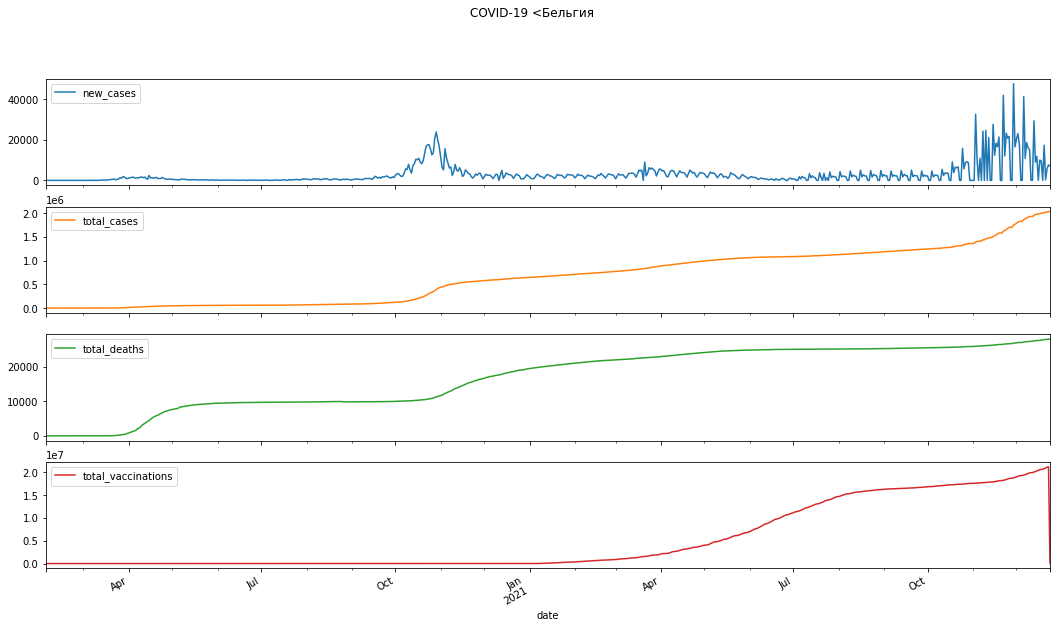

In [22]:
#построим общий график для метрик
df_new[['new_cases', 'total_cases', 'total_deaths', 'total_vaccinations']].plot(subplots=True, figsize=(18, 10), title = 'COVID-19 <Бельгия');

---
На графике новых случаев заболевания заметны 4 подъема уровней заболеваемости: 

1й - незначительный подъем уровня заболеваемости, без сильных пиков, однако, приведший к резкому подъему количества смертей, вероятно, в связи с отсутствием эффективного протокола лечения новой короновирусной инфекции и агрессивной его формы. 

2й - значительный подъм уровня заболеваемости с пиком в более 20тыс случаев в день, также приведший к значительному увеличению количества смертей, но уже более плавному, чем в первую волну. Больше таких резких подъемов количества смертей на графике не наблюдается, их число растет очень медленно, несмотря на самую большую 4ю волну с пиком более 47тыс случаев заболеваний в день, что может быть связано с началом массовой вакцинации, разработкой эффективного протокола лечения и выработкой коллективного иммунитета. 

---

## Построение моделей, анализ результатов.

### Для анализа цикличности и тренда воспользуемся фильтром Ходрика-Прескотта.

---
Фильтр Ходрика-Прескотта – метод сглаживания временного ряда, который используется для выделения длительных тенденций (сезонных колебаний и трендов) из временного ряда.

---

In [23]:
from statsmodels.tsa.filters.hp_filter import hpfilter
#проверим на цикличность и тренд данные о новых случаях заболевания.
new_cases_cycle, new_cases_trend = hpfilter(df_new['new_cases'], lamb = 100)
df_new['trend'] = new_cases_trend

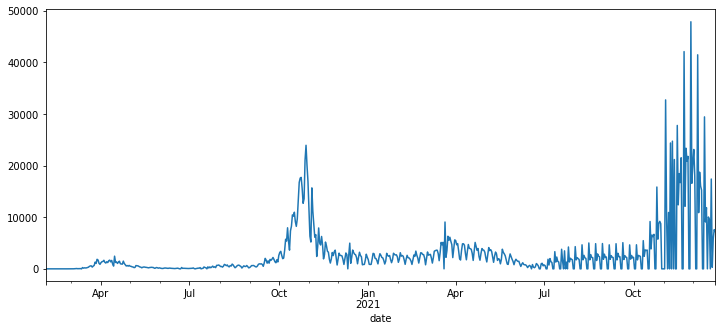

In [24]:
df_new['new_cases'].plot(figsize=(12,5));

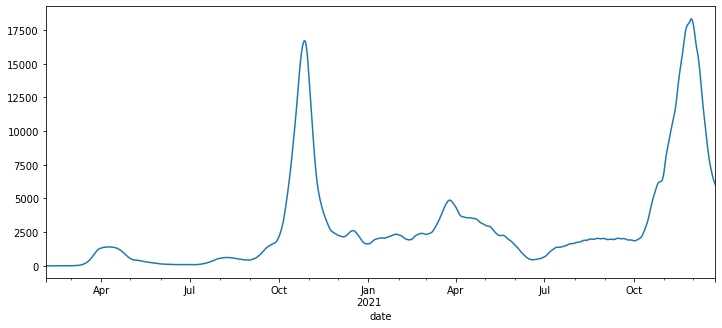

In [25]:
# построим график тренда
df_new['trend'].plot(figsize=(12,5));

---
Тренд отсутствует, что говорит о том, что данный временной ряд является скорее всего стационарным.

---

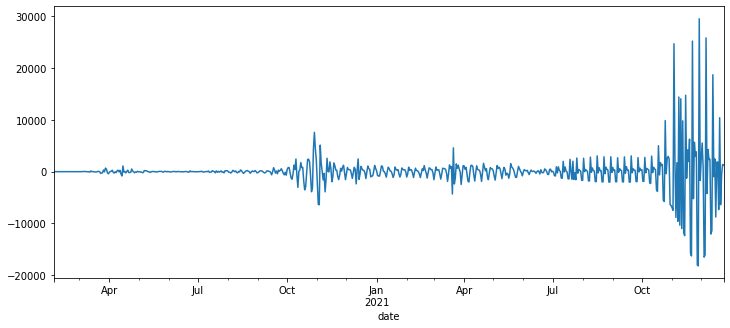

In [26]:
# построим график цикла
df_new['cycle'] = new_cases_cycle
df_new['cycle'].plot(figsize=(12,5));

---
По данному графику сложно судить о цикличности, т.к. наблюдаемый период пока относительно небольшой. Однако, стоит отметить, что пики 1й и 3й волны заболеваемости приходятся на вторую половину марта, а 2й и 4й волн на начало ноября, что может говорить о цикличности. 

---

## Проверим ряд на стационарность

---
Для проверки стационарности ряда воспользуемся тестом Дикки-Фуллера. Он проверяет ряд на наличие единичных корней. Временной ряд имеет единичный корень (хотя бы один), если его первые разности образуют стационарный ряд.

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики, поэтому в случае нестационарности исходного ряда предсказания окажутся неверными.

---

In [30]:
adfuller(df_new['new_cases'])
dftest = adfuller(df_new['new_cases'])
print ('adf: ', dftest[0])
print ('p-value: ', dftest[1])
print ('critical values: ', dftest[4])
#сравниваем найденное p-value - достоверность статистики с critical_values - критическими значениями с уровнем значимости 5%:
if dftest[0]>dftest[4]['5%']:
    print ('есть единичные корни, ряд нестационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -3.6009235353419684
p-value:  0.005743396263806368
critical values:  {'1%': -3.4400894360545475, '5%': -2.865837730028723, '10%': -2.5690586760471605}
единичных корней нет, ряд стационарен


---
Вывод: ряд является стационарным. 

---

### ETS декомпозиция

---
Это метод для автоматического разложения временной ряда на тренд, сезонность и остаток.

Используем аддитивную модель ('additive').

---

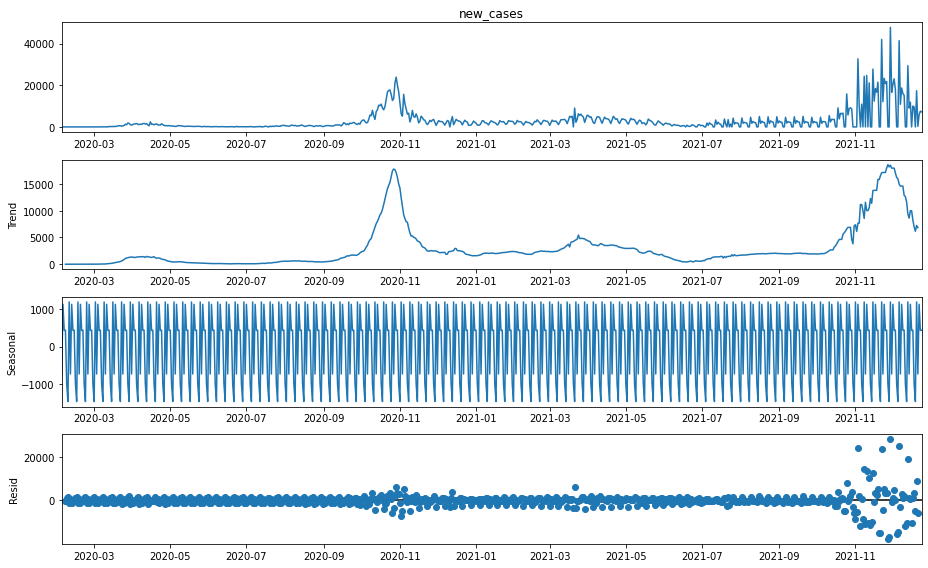

In [31]:
plt.rcParams['figure.figsize'] = (13, 8)
result = seasonal_decompose(df_new['new_cases'],model='additive')
result.plot();

---
***Промежуточный вывод:***

На графике представлено распределение в пиковую нагрузку в ноябре 2020 и  2021. Наблюдаем недельную сезонность.

---

In [32]:
# построим матрицу корреляции признаков
df_new.corr()

,new_cases,total_cases,total_deaths,total_vaccinations,trend,cycle
new_cases,1.000000,0.379587,0.261757,0.301969,0.752917,0.667142
total_cases,0.379587,1.000000,0.925507,0.859732,0.506702,0.003194
total_deaths,0.261757,0.925507,1.000000,0.719937,0.350822,0.000608
total_vaccinations,0.301969,0.859732,0.719937,1.000000,0.406780,-0.001636
trend,0.752917,0.506702,0.350822,0.406780,1.000000,0.012053
cycle,0.667142,0.003194,0.000608,-0.001636,0.012053,1.000000


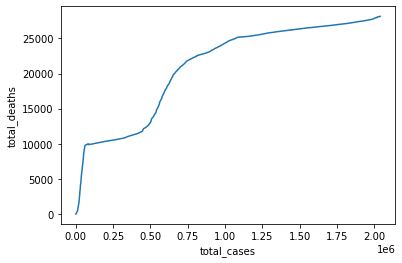

In [ ]:
# построим график зависимости total_cases от total_deaths
sns.lineplot(data = df_new, x = 'total_cases', y = 'total_deaths')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



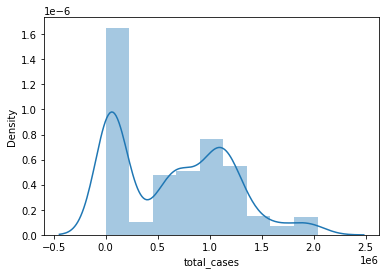

In [ ]:
# график плотности распределения total_cases
sns.distplot(df_new.total_cases)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



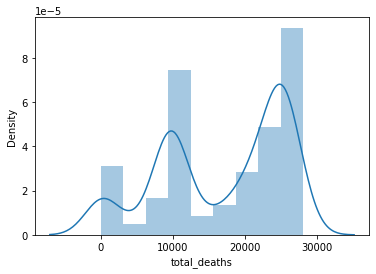

In [ ]:
# график плотности распределения total_deaths
sns.distplot(df_new.total_deaths)

---
***Промежуточный вывод:***

Видим высокий уровень корреляции между кол-вом заболеваний и смертей, что свидетельствует о воздействии сходных факторов на уровень заболеваемости и общей смертности, где на графике видна практически близкая к линейной зависимости этих двух признаков.

Также на графиках KDE видим, что графики распределения подобны, благодаря этому наблюдению можно сформулировать гипотезу исследования:

***Если общее количество смертельных случаев выходит на плато, связано ли это со снижением новых случаев заражения?***

Для этого построим прогнозную модель расчёта новых случаев заражения.

---

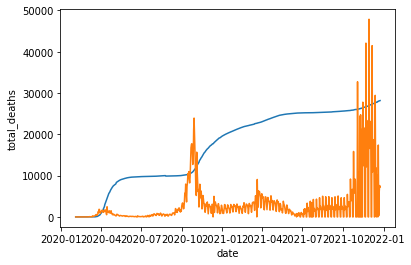

In [ ]:
sns.lineplot(data = df_new, x = 'date', y = 'total_deaths')
sns.lineplot(data = df_new, x = 'date', y = 'new_cases')

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



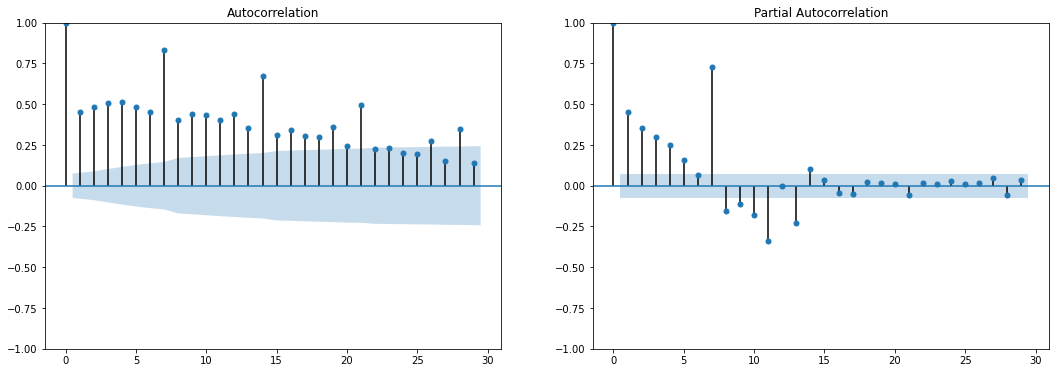

In [ ]:
# строим графики автокорреляции и частичной автокорреляции временного ряда.

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

plot_acf(df_new.new_cases, ax=ax1);
plot_pacf(df_new.new_cases, ax=ax2);

---
Значимый коэффициент корреляции для лагов 7, 14, 21 и 28 говорит о недельной цикличности.

График частичной автокорреляции характеризуется резко выделяющимся значением на седьмом лаге, что также говорит о возможной недельной цикличности.

---

### Обучающая/контрольная выборки

---
Разделим датасет на тренировочную и тестовую выборки, которые будут использованы в дальнейшем для обучения модели и для оценки ее качества.

---

In [ ]:
# выделяем выборки, где тестовая выборка -  10 последних наблюдений
train = df_new.iloc[:len(df_new)-10]
test = df_new.iloc[len(df_new)-10:]

## 1й метод прогнозирования - SARIMA

---
***Описание модели SARIMA:***
 Сезонное авторегрессионное интегрированное скользящее среднее, SARIMA или Seasonal ARIMA, является расширением ARIMA, которое явно поддерживает одномерные данные временных рядов с сезонным компонентом. Он добавляет три новых гиперпараметра для указания авторегрессии (AR), разности (I) и скользящего среднего (MA) для сезонной составляющей ряда, а также дополнительный параметр для периода сезонности.

Сезонная модель ARIMA формируется путем включения дополнительных сезонных терминов в ARIMA. Сезонная часть модели состоит из терминов, которые очень похожи на несезонные компоненты модели, но включают обратные сдвиги сезонного периода.

***Элементы тренда***


Есть три элемента тренда, которые требуют настройки.

Они такие же, как модель ARIMA, в частности:

p: Порядок авторегрессии тренда.

d: Порядок изменения тренда.

q: Тренд скользящей средней.

***Сезонные элементы***


Есть четыре сезонных элемента, которые не являются частью ARIMA, которые должны быть настроены:

P: Сезонный порядок авторегрессии.

D: Порядок сезонных разниц.

Q: Сезонный порядок скользящих средних.

m: Количество временных шагов за один сезонный период.

---

In [ ]:
#Запустим pmdarima.auto_arima чтобы получить набор параметров для нашей модели, учитываем сезонность и указываем период сезонности = 1 неделя
auto_arima(df_new['new_cases'],seasonal=True, m=7).summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  690
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -6375.328
Date:                            Sun, 26 Dec 2021   AIC                          12766.657
Time:                                    14:28:43   BIC                          12802.939
Sample:                                         0   HQIC                         12780.692
                                            - 690                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0205      0.026    -38.866      0.000      -1.072      -0.969
ar.L2         -0.5227      0.028    -18.362      0.000      -0.578      -0.467
ar.L3         -0.3778      0.017    -22.381      0.000      -0.411      -0.345
ma.L1          0.1400      0.027      5.241      0.000       0.088       0.192
ma.L2         -0.4558      0.028    -16.348      0.000      -0.510      -0.401
ar.S.L7        0.7125      0.016     44.607      0.000       0.681       0.744
ar.S.L14       0.1140      0.018      6.317      0.000       0.079       0.149
sigma2      6.312e+06   1.03e+05     61.480      0.000    6.11e+06    6.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             29442.08
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             267.87   Skew:                             1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+14. Standard errors may be unstable.
"""

---
Получили следующие оптимальные параметры нашей модели: (3, 1, 2)x(2, 0, [], 7).

---

In [ ]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['new_cases'],order=(3, 1, 2), seasonal_order=(2, 0, [], 7))

#обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

#получаем результаты
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  680
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -6244.911
Date:                            Sun, 26 Dec 2021   AIC                          12505.823
Time:                                    14:31:56   BIC                          12541.988
Sample:                                02-04-2020   HQIC                         12519.822
                                     - 12-14-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1147      0.027    -41.350      0.000      -1.168      -1.062
ar.L2         -0.6599      0.028    -23.514      0.000      -0.715      -0.605
ar.L3         -0.4167      0.015    -27.655      0.000      -0.446      -0.387
ma.L1          0.2170      0.028      7.814      0.000       0.163       0.271
ma.L2         -0.3552      0.029    -12.318      0.000      -0.412      -0.299
ar.S.L7        0.6999      0.015     47.656      0.000       0.671       0.729
ar.S.L14       0.1920      0.017     11.260      0.000       0.159       0.225
sigma2       5.63e+06   8.79e+04     64.043      0.000    5.46e+06     5.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             45391.45
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):             234.30   Skew:                             1.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.21e+14. Standard errors may be unstable.
"""

In [ ]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename(' Predictions SARIMAX(3, 1, 2)x(2, 0, [], 7)	')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



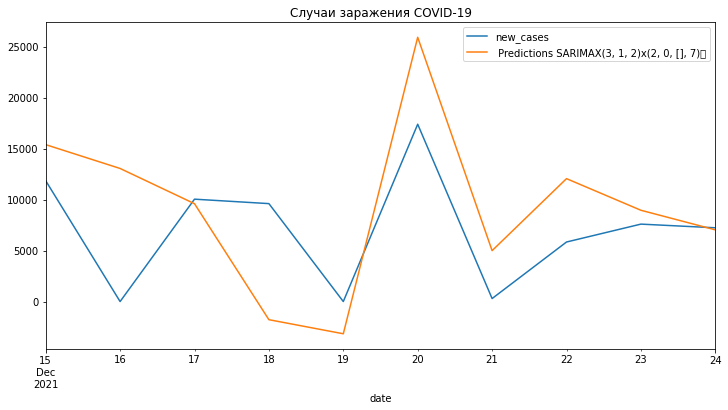

In [ ]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [ ]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], prediction_sarimax)
mse_error = mean_squared_error(test['new_cases'], prediction_sarimax)
rmse_error = rmse(test['new_cases'], prediction_sarimax)
mape_error = np.mean(np.abs(prediction_sarimax - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MAPE Error: {mape_error:11.10}')

SARIMAX(3, 1, 2)x(2, 0, [], 7) MAE Error: 5258.112475
SARIMAX(3, 1, 2)x(2, 0, [], 7) MSE Error: 45796592.74
SARIMAX(3, 1, 2)x(2, 0, [], 7) RMSE Error: 6767.317987
SARIMAX(3, 1, 2)x(2, 0, [], 7) MAPE Error:         inf


In [ ]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df_new['new_cases'],order=(3, 1, 2), seasonal_order=(2, 0, [], 7))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  690
Model:             SARIMAX(3, 1, 2)x(2, 0, [], 7)   Log Likelihood               -6375.328
Date:                            Sun, 26 Dec 2021   AIC                          12766.657
Time:                                    14:37:01   BIC                          12802.939
Sample:                                02-04-2020   HQIC                         12780.692
                                     - 12-24-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0205      0.026    -38.866      0.000      -1.072      -0.969
ar.L2         -0.5227      0.028    -18.362      0.000      -0.578      -0.467
ar.L3         -0.3778      0.017    -22.381      0.000      -0.411      -0.345
ma.L1          0.1400      0.027      5.241      0.000       0.088       0.192
ma.L2         -0.4558      0.028    -16.348      0.000      -0.510      -0.401
ar.S.L7        0.7125      0.016     44.607      0.000       0.681       0.744
ar.S.L14       0.1140      0.018      6.317      0.000       0.079       0.149
sigma2      6.312e+06   1.03e+05     61.480      0.000    6.11e+06    6.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             29442.08
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             267.87   Skew:                             1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        34.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+14. Standard errors may be unstable.
"""

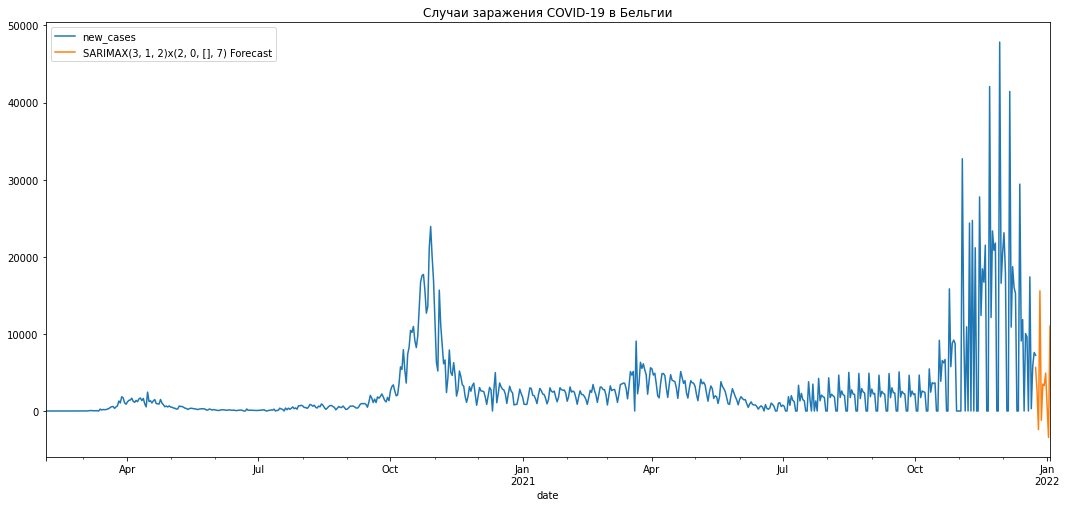

In [ ]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels').rename('SARIMAX(3, 1, 2)x(2, 0, [], 7) Forecast')

#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(18,8),title='Случаи заражения COVID-19 в Бельгии') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

---
***Вывод работы метода SARIMA.***
Модель SARIMA неудовлетворительно показала себя на нашем датасете, прогноз в большинстве случаев далек от реальных данных, лишь повторяет направление с реальными данными. Значение среднеквадратичной ошибки в количестве 6767 случаев это много. Причинами в данном случае, скорее всего, является наличие ряда других признаков, которые оказывают влияние на количество возникновения новых случаев заболевания, и которые мы учитываем в данной модели. На такой прогноз при принятии важных решений опираться бы не следовало. 

---

### 2й метод прогнозирования - PROPHET

---
В основе модели Prophet лежит процедура подгонки аддитивных регрессионных моделей со следующими четырьмя основными компонентами: тренд, сезонность, аномальные дни(праздники) и ошибки (содержит информацию, которая не учтена моделью).

---

In [ ]:
# подготовим данные для модели
train_prophet = train[['date','new_cases']]
test_prophet = test[['date','new_cases']]

In [ ]:
# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [ ]:
# подготовим данные по всему датасету для модели
df_new_prophet = df_new[['date','new_cases']]
df_new_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [ ]:
# создаем модель с подобранными параметрами
model_prophet = Prophet(seasonality_mode='multiplicative')

In [ ]:
#обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet)

Exception: ignored

---
***Промежуточные выводы:***


Алгоритм проигнорировал, выбирая параметры

1. `Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.`

    - годовую сезонность (*для годовой сезонности нам нужно иметь данные минимум за 2 года, чтобы суметь использовать ее в модели*)


2. `INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.`

    - дневную сезонность (*дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам*).

Зато он обнаружил недельную сезонность и использовал его при настройке модели.

---

In [ ]:
# говорим профету сделать дата-фрейм на 10 дней вперед
future_prophet = model_prophet.make_future_dataframe(periods=10)

In [ ]:
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-02-04,-390.379081,-4995.864477,4303.130494,-390.379081,-390.379081,-0.296619,-0.296619,-0.296619,-0.296619,-0.296619,-0.296619,0.0,0.0,0.0,-274.585366
1,2020-02-05,-382.334095,-5148.167188,4117.187548,-382.334095,-382.334095,0.540810,0.540810,0.540810,0.540810,0.540810,0.540810,0.0,0.0,0.0,-589.104089
2,2020-02-06,-374.289109,-4794.856180,4107.756716,-374.289109,-374.289109,0.140152,0.140152,0.140152,0.140152,0.140152,0.140152,0.0,0.0,0.0,-426.746522
3,2020-02-07,-366.244123,-5149.373753,4282.276672,-366.244123,-366.244123,0.180595,0.180595,0.180595,0.180595,0.180595,0.180595,0.0,0.0,0.0,-432.386080
4,2020-02-08,-358.199137,-4896.991929,4282.299970,-358.199137,-358.199137,-0.737097,-0.737097,-0.737097,-0.737097,-0.737097,-0.737097,0.0,0.0,0.0,-94.171591


In [ ]:
#устанавливаем индекс
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() # проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-02-04,2020-02-04,-390.379081,-4995.864477,4303.130494,-390.379081,-390.379081,-0.296619,-0.296619,-0.296619,-0.296619,-0.296619,-0.296619,0.0,0.0,0.0,-274.585366
2020-02-05,2020-02-05,-382.334095,-5148.167188,4117.187548,-382.334095,-382.334095,0.540810,0.540810,0.540810,0.540810,0.540810,0.540810,0.0,0.0,0.0,-589.104089
2020-02-06,2020-02-06,-374.289109,-4794.856180,4107.756716,-374.289109,-374.289109,0.140152,0.140152,0.140152,0.140152,0.140152,0.140152,0.0,0.0,0.0,-426.746522
2020-02-07,2020-02-07,-366.244123,-5149.373753,4282.276672,-366.244123,-366.244123,0.180595,0.180595,0.180595,0.180595,0.180595,0.180595,0.0,0.0,0.0,-432.386080
2020-02-08,2020-02-08,-358.199137,-4896.991929,4282.299970,-358.199137,-358.199137,-0.737097,-0.737097,-0.737097,-0.737097,-0.737097,-0.737097,0.0,0.0,0.0,-94.171591


---
Промежуточные выводы:

Основные поля в прогнозе следующие:
- `ds` — дата прогноза
- `yhat` — спрогнозированное значение

---


In [ ]:
prediction_prophet[['ds', 'yhat']] # оставим только нужные

,ds,yhat
ds,,
2020-02-04,2020-02-04,-274.585366
2020-02-05,2020-02-05,-589.104089
2020-02-06,2020-02-06,-426.746522
2020-02-07,2020-02-07,-432.386080
2020-02-08,2020-02-08,-94.171591
...,...,...
2021-12-20,2021-12-20,28139.288169
2021-12-21,2021-12-21,9839.867608
2021-12-22,2021-12-22,21696.365822


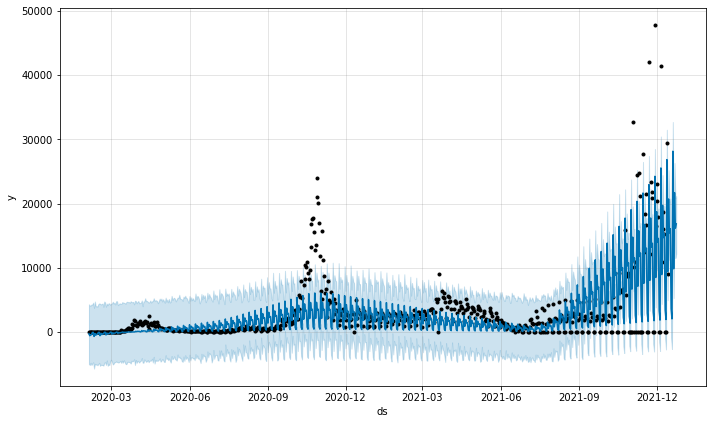

In [ ]:
#сравниваем прогноз и тестовую выборку, где черные точки - выборка
model_prophet.plot(prediction_prophet);

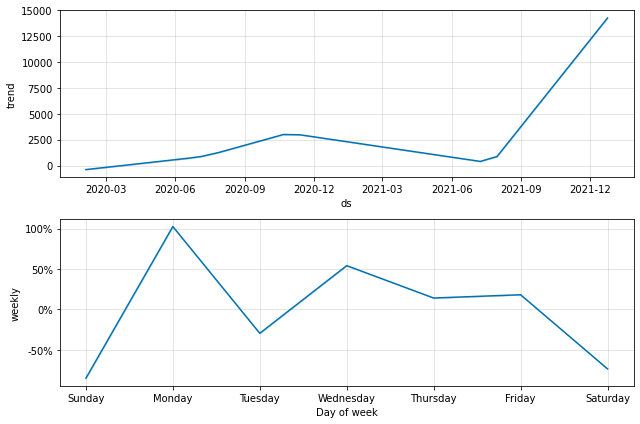

In [ ]:
# разложим ряд на основные компоненты — тренд и сезонность
model_prophet.plot_components(prediction_prophet);

In [ ]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 9268.704087
Prophet MSE Error: 101691337.0
Prophet RMSE Error: 10084.21226
Prophet MAPE Error:         inf


In [ ]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_new_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# говорим профету сделать дата-фрейм на 10 дней вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

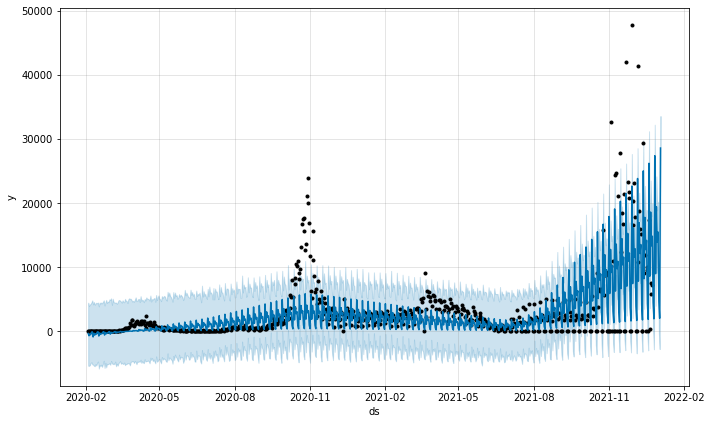

In [ ]:
#сравниваем прогноз и всю выборку, где черные точки - входная выборка
fut_model_prophet.plot(fut_fcast_prophet);

In [ ]:
#устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [ ]:
# убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-02-04,2020-02-04,-469.497906,-5353.518028,4479.662593,-469.497906,-469.497906,-0.311599,-0.311599,-0.311599,-0.311599,-0.311599,-0.311599,0.0,0.0,0.0,-323.202594
2020-02-05,2020-02-05,-459.673256,-5384.576263,3960.731039,-459.673256,-459.673256,0.478653,0.478653,0.478653,0.478653,0.478653,0.478653,0.0,0.0,0.0,-679.697284
2020-02-06,2020-02-06,-449.848606,-5287.890851,4194.809839,-449.848606,-449.848606,0.053327,0.053327,0.053327,0.053327,0.053327,0.053327,0.0,0.0,0.0,-473.837786
2020-02-07,2020-02-07,-440.023956,-4952.857744,4288.245682,-440.023956,-440.023956,0.165051,0.165051,0.165051,0.165051,0.165051,0.165051,0.0,0.0,0.0,-512.650399
2020-02-08,2020-02-08,-430.199306,-4819.727443,4527.044315,-430.199306,-430.199306,-0.647531,-0.647531,-0.647531,-0.647531,-0.647531,-0.647531,0.0,0.0,0.0,-151.631962


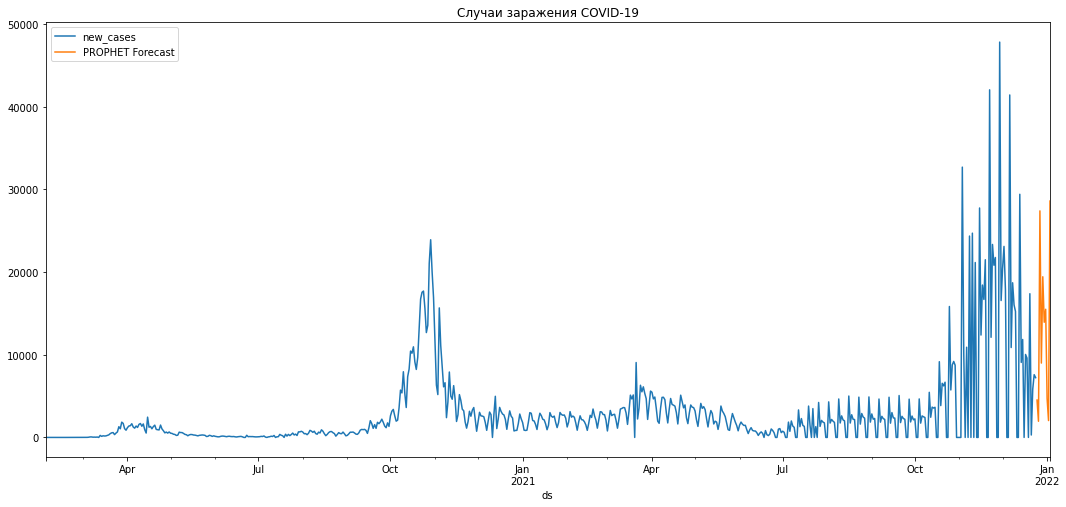

In [ ]:
#строим график на будущее
ax = df_new_prophet['y'].plot(legend=True, figsize=(18,8),title='Случаи заражения COVID-19') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["new_cases", "PROPHET Forecast"]);

---
***Выводы работы метода PROPHET***
Модель Prophet показала себя еще хуже, чем SARIMA, среднеквадватическое отклонение - 10084 случаев в день. 

---

### 3й метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing)

---
Экспоненциальное сглаживание также называется моделью Хольта-Винтерса - тройное экспоненциального сглаживания, моделирует следующий временной шаг как экспоненциально взвешенную линейную функцию наблюдений на предыдущих временных шагах с учетом тенденций и сезонности.

Метод подходит для одномерных временных рядов с трендовыми и / или сезонными компонентами.

---

In [ ]:
# создаем модель с подобранными параметрами
model_exps = ExponentialSmoothing(train['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность

#обучаем модель на обучающей выборке данных
model_exps.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
#посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 0.4,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': -0.05454545454545457,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.1464285714285714,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.0001,
 'use_boxcox': False}

In [ ]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [ ]:
test.index[0]

Timestamp('2021-12-15 00:00:00')

In [ ]:
test.index[-1]

Timestamp('2021-12-24 00:00:00')

In [ ]:
prediction_exps

array([13822.32230138, 13823.63506842, 13824.94783546, 13826.26060249,
       13827.57336953, 13828.88613656, 13830.1989036 , 13831.51167064,
       13832.82443767, 13834.13720471])

In [ ]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2021-12-10 00:00:00", periods=10, freq="D")

prediction_exps.columns = ['prediction_exps']

In [ ]:
#проверим датасет
prediction_exps.head()

,prediction_exps
2021-12-10,13822.322301
2021-12-11,13823.635068
2021-12-12,13824.947835
2021-12-13,13826.260602
2021-12-14,13827.573370


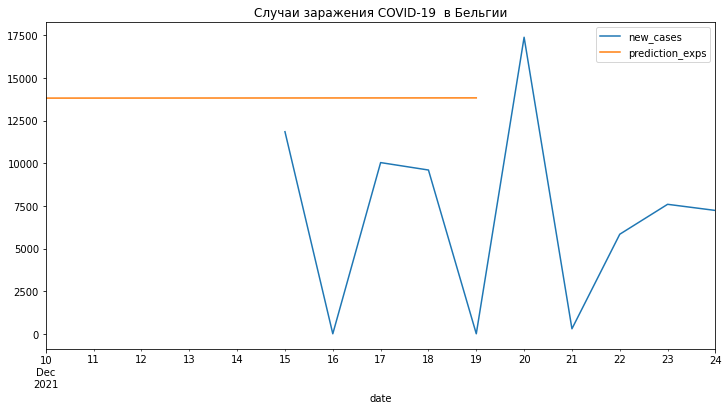

In [ ]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19  в Бельгии')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [ ]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], prediction_exps['prediction_exps'])
mse_error = mean_squared_error(test['new_cases'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['new_cases'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(3, 1, 2)x(2, 0, [], 7) MAPE Error: {mape_error:11.10}')

SARIMAX(3, 1, 2)x(2, 0, [], 7) MAE Error: 7556.252526
SARIMAX(3, 1, 2)x(2, 0, [], 7) MSE Error: 76067803.45
SARIMAX(3, 1, 2)x(2, 0, [], 7) RMSE Error: 8721.685814
SARIMAX(3, 1, 2)x(2, 0, [], 7) MAPE Error:         inf


In [ ]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df_new['new_cases'], seasonal_periods=7, trend = 'add') # недельная сезонность
fut_model_exps.fit()

#задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df_new)-1, end=len(df_new)+9)

#преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2021-12-19", periods=11, freq="D")
fut_fcast_exps.columns = ['fut_fcast_exps']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
#проверим
fut_fcast_exps.head()

,fut_fcast_exps
2021-12-19,8480.500703
2021-12-20,8298.590400
2021-12-21,8299.349843
2021-12-22,8300.109286
2021-12-23,8300.868728


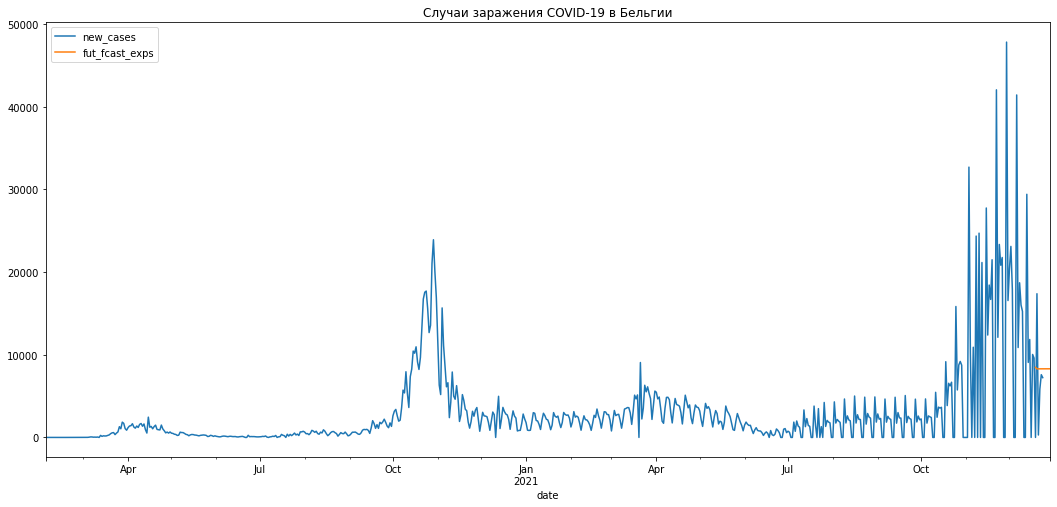

In [ ]:
#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(18,8),title='Случаи заражения COVID-19 в Бельгии') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

---
***Выводы работы метода Экспоненциальное сглаживание***


Данная модель сгладила пики и показала наименьшую из трех рассмотренных моделей среднеквадратическую ошибку, но она также довольна высока - 8721 случаев в день.

## Выводы

---
- Проведен анализ данных с использованием современных методов обработки статистической информации. 

- Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.

- Результаты анализа представленных данных помогли выявить выход на плато количества смертей, несмотря на самую сильную волну подъема уровня заболеваемости на фоне введения всеобщей вакцинации населения Бельгии, что может говорить о её эффективности. 

- Ни одна из моделей не показала достаточно надежного прогноза применимо к имеющимся данным. Наименьшая среднеквадратическая ошибка у модели Экспоненциального сглаживания - 8721 случай в день. Для более точного прогнозирования нужно большее количество наблюдений. Однако, опираясь на данный прогноз, с учетом среднеквадратической ошибки, можно судить об эффективности принимаемых мер и принятии дальшейших решений в борьбе с заболеванием. 

---